In [12]:
from tqdm import tqdm
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [3]:
import json
with open("mongo_dump.json") as file:
    communities_unprocessed = json.load(file)['communities']

In [4]:
user_id2community_list = {
    user_description['_id']: user_description['communities'] for user_description in communities_unprocessed
}

In [6]:
from collections import defaultdict
community_id2user_list = defaultdict(list)
user_id2community_list = defaultdict(list)
community_id2description = dict()
for user_description in tqdm(communities_unprocessed):
    user_id = user_description['_id']
    for community_description in user_description['communities']:
        if community_description['type'] == 'profile':
            continue
        community_id = community_description['id']
        community_id2user_list[community_id].append(user_id)
        user_id2community_list[user_id].append(community_id)
        community_id2description[community_id] = community_description

100%|██████████████████████████████████| 92121/92121 [00:06<00:00, 13540.48it/s]


In [8]:
frequencies = {community_id: len(user_list) for community_id, user_list in community_id2user_list.items()}

In [9]:
top200_communities = sorted(frequencies.items(), key=lambda x: x[1], reverse=True)[:200]

In [35]:
top10_communities_df.iloc[0].description

'Fiesta.Ru — для людей, интересующихся событиями Петербурга и всем, что связано с городом. Мы ищем необычные, интересные мероприятия, делимся фотографиями и рассказываем о неформальных достопримечательностях города.'

In [36]:
top10_communities_df = pd.DataFrame(
    [community_id2description[top200_communities[i][0]] for i in range(10)],
    columns=['id', 'name', 'activity'],
)
top10_communities_df['scraped_subscribers'] = top10_communities_df.id.apply(lambda id: frequencies[id])
top10_communities_df.to_csv('table_community.csv')

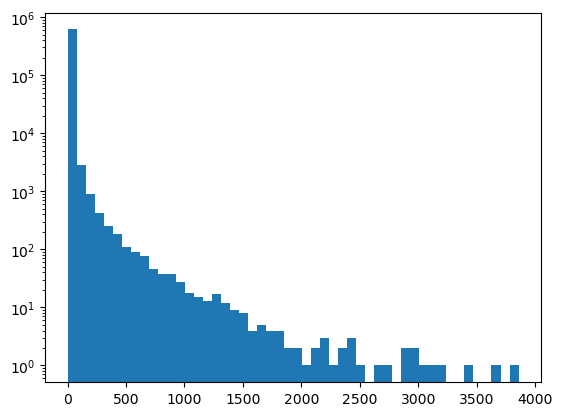

In [9]:
plt.hist(frequencies.values(), bins=50)
plt.yscale('log')

In [13]:
user_vectors = {
    user_id: np.array(
        [community_freq[0] in user_id2community_list[user_id] for community_freq in top200_communities],
    )
    for user_id in user_id2community_list.keys()
}

In [17]:
n_subscriptions = [vector.sum() for vector in user_vectors.values()]

In [34]:
bins = np.linspace(0.0, 60.0, 61)

In [37]:
n_subscriptions.count(0)

16577

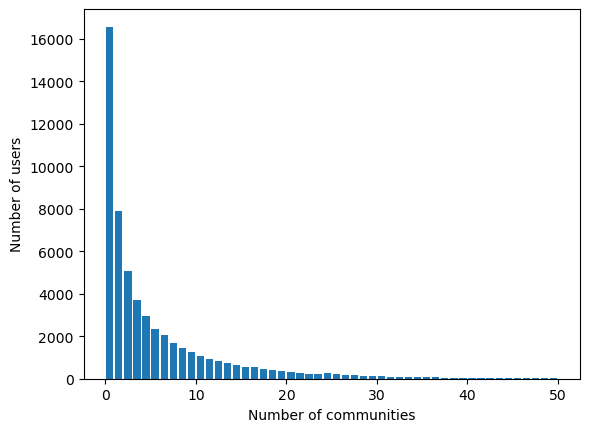

In [38]:
plt.hist(n_subscriptions, bins=np.linspace(0.0, 50.0, 51), rwidth=0.8)
plt.xlabel("Number of communities")
plt.ylabel("Number of users")
plt.savefig("figures/n_subscriptions_to_community_distribution.pdf")

In [39]:
vectors = np.array(list(user_vectors.values()))

In [65]:
nonzero_vectors = vectors[vectors.any(axis=0)]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 54595 but corresponding boolean dimension is 200

In [66]:
from sklearn.manifold import TSNE
tsne = TSNE(2, n_iter=5000)
embedding = tsne.fit_transform(vectors)

In [67]:
embedding.shape

(54595, 2)

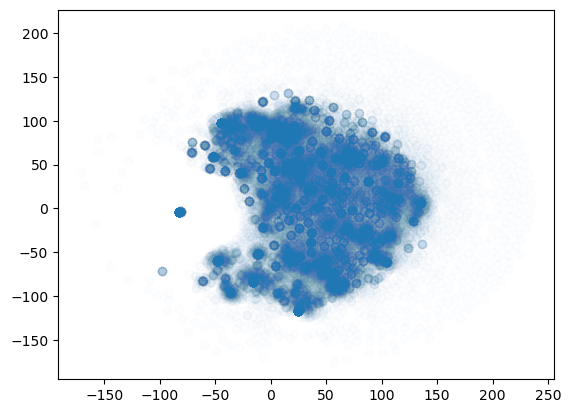

In [68]:
plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.01)